# Thermo-poro-elasticity with nonlinear convection: Cantilever problem

We solve the nonlinear **thermo-poro-elasticity** problem described by the following set of the equations:

$$
    \begin{aligned}
-\boldsymbol\nabla\cdot(2\mu\boldsymbol\nabla_s\boldsymbol{u} + (\lambda\boldsymbol\nabla\cdot\boldsymbol{u}-\alpha p -\beta T)\mathbb{I}_d) &= \boldsymbol{f}, \quad\text{in}\; \Omega, \\
\partial_t(a_0 T - b_0 p + \beta\boldsymbol\nabla\cdot\boldsymbol{u}) -\gamma\boldsymbol\nabla T\cdot\kappa\boldsymbol\nabla p -\boldsymbol\nabla\cdot(\Theta\boldsymbol\nabla T) &= h, \quad\text{in}\; \Omega, \\
\partial_t(c_0 p - b_0 T + \alpha\boldsymbol\nabla\cdot\boldsymbol{u}) -\boldsymbol\nabla\cdot(\kappa\boldsymbol\nabla p) &= g, \quad\text{in}\; \Omega,
    \end{aligned}
$$

assuming null forcing terms $\boldsymbol{f}$, $g$, snd $h$, null initial conditions, and 

$$
  \begin{aligned}
\boldsymbol{u} &= \boldsymbol{0}, \qquad\;\quad\text{ on } \Gamma_D := \{\boldsymbol{x}\in\partial\Omega\, |\, x_1 = 0 \},
\\
\boldsymbol{\sigma}\boldsymbol{n} &= (0 , -1)^{T}, \;\;\text{ on } \Gamma_N:= \{\boldsymbol{x}\in\partial\Omega\, |\, x_2 = 1 \},
\\
\boldsymbol{\sigma}\boldsymbol{n} &= \boldsymbol{0}, \qquad\;\quad\text{ on } \partial\Omega\setminus(\Gamma_D\cup\Gamma_N),
\\
\Theta\boldsymbol\nabla T\cdot\boldsymbol{n} &= 0, 
\qquad\;\quad\text{ on } \partial\Omega,
\\
\kappa\boldsymbol\nabla p\cdot\boldsymbol{n} &= 0, 
\qquad\;\quad\text{ on } \partial\Omega.
  \end{aligned}
$$

We consider the **four-field formulation** obtained by introducing the additional variable 
$\varphi = \lambda \boldsymbol\nabla\cdot\boldsymbol{u} - \alpha p -\beta T$. We employ a **dG SIP discretization** in space and a backward Euler time advancing scheme. We linearized the discrete problem in two ways: (i) adopting a semi-implicit time scheme, or (ii) by the Newton method. 

## Implementation

In [ ]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# mesh generation
#mesh = UnitSquareMesh(64, 64, 'crossed')
square = Rectangle(Point(0.0, 0.0), Point(1.0, 1.0))
mesh = generate_mesh(square, 64)

# definition of the discrete spaces
U = VectorElement('DG', mesh.ufl_cell(), 1)
Q = FiniteElement('DG', mesh.ufl_cell(), 1)
P = FiniteElement('DG', mesh.ufl_cell(), 1)
X = FunctionSpace(mesh, MixedElement([U, Q, P, P]))

# problem data
T = 0.005              # final simulation time
mu = Constant(1.0)     # mu fixed as reference parameter (keep it = 1)
lam = Constant(10.0)   # lam can be arbitrarly large (nearly incompressible case)
a_0 = Constant(0.0)    # a_0 can be equal to 0
b_0 = Constant(0.0)    # b_0 < a_0 and b_0 < c_0 (physical constraints)
c_0 = Constant(0.01)   # c_0 can be equal to 0
kappa = Constant(0.02) # strictly positive
theta = Constant(0.2)  # strictly positive
alpha = Constant(1.0)  # strictly positive and smaller or equal to 1
beta = Constant(0.8)   # strictly positive and smaller or equal to 1
iota = Constant(1.0)   # 0: linear case, 1: nonlinear advection

t_n = Expression(('0.0', '-1.0'), t=0.0, degree=0) 
dt = 0.001

# traction boundary
class TopBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 1.0)

# clamped boundary
class LeftBoundary(SubDomain):
    def inside (self, x, on_boudary):
        return on_boudary and near(x[0], 0.0)

top = TopBoundary()
left = LeftBoundary()
boundary_markers = MeshFunction('size_t', mesh, 1, 0)
top.mark(boundary_markers, 1)
left.mark(boundary_markers, 2)
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)

solving step 0.001
solving step 0.002
solving step 0.003
solving step 0.004
solving step 0.005


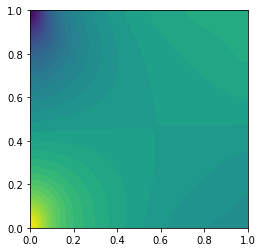

In [ ]:
# assembling linearized discrete problem
u, phi, p, tt = TrialFunctions(X)
v, psi, q, rr = TestFunctions(X)
x_old = Function(X)
u_old, phi_old, p_old, tt_old = split(x_old)
    
n = FacetNormal(mesh)
h = CellDiameter(mesh)
h_avg = (h('+') + h('-'))/2
gamma = 10.1
delta = 3.1

a1 = (2.0*inner(sym(grad(u)), sym(grad(v))) + phi*div(v) - div(u)*psi)*dx  \
   - 2.0*inner(dot(avg(sym(grad(u))), n('+')), jump(v))*dS \
   - 2.0*inner(jump(u), dot(avg(sym(grad(v))), n('+')))*dS \
   - 2.0*inner(dot(sym(grad(u)), n), v)*ds(2) \
   - 2.0*inner(u, dot(sym(grad(v)), n))*ds(2) \
   + 2.0*gamma/h_avg*inner(jump(u), jump(v))*dS \
   + 2.0*gamma/h*inner(u, v)*ds(2) \
   + inner(jump(u, n), avg(psi))*dS - inner(jump(v, n), avg(phi))*dS \
   + inner(u, n)*psi*ds(2) - inner(v, n)*phi*ds(2) \
   + delta*h_avg*jump(phi)*jump(psi)*dS 

a2 = (1.0/lam)*(phi+alpha*p+beta*tt)*(psi+alpha*q+beta*rr)*dx \
   + (b_0*(p-tt)*(q-rr) + (c_0-b_0)*p*q + (a_0-b_0)*tt*rr)*dx

a3 = dt*kappa*dot(grad(p), grad(q))*dx \
   - dt*kappa*dot(avg(grad(q)), jump(p, n))*dS \
   - dt*kappa*dot(jump(q, n), avg(grad(p)))*dS \
   + dt*kappa*gamma/h_avg*dot(jump(p, n), jump(q, n))*dS 

a4 = dt*theta*dot(grad(tt), grad(rr))*dx \
   - dt*theta*dot(avg(grad(rr)), jump(tt, n))*dS \
   - dt*theta*dot(jump(rr, n), avg(grad(tt)))*dS \
   + dt*theta*gamma/h_avg*dot(jump(tt, n), jump(rr, n))*dS 
    
a = a1 + a2 + a3 + a4 - dt*iota*dot(kappa*grad(p), grad(tt_old))*rr*dx
    
L = dot(t_n, v) * ds(1) + (p_old*(c_0*q-b_0*rr) + tt_old*(a_0*rr-b_0*q))*dx \
  + (1/lam)*(alpha*p_old+beta*tt_old+phi_old)*(alpha*q+beta*rr)*dx

# advance in time
time = 0.0
x = Function(X)
u, phi, p, tt = x.split()

while time < T:
  time += dt
  t_n.t = time

  print('solving step {}'.format(time))
  x_old.assign(x)
  solve(a == L, x)
  u, phi, p, tt = x.split()

plot(p)

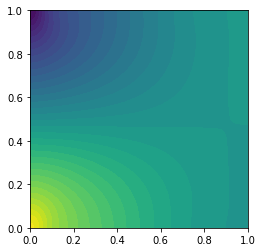

In [ ]:
plot(tt)